In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
df_steam_prices_summary_diff = pd.read_csv('https://docs.google.com/uc?export=download&id=1S4n6szfQvsiqatTsvxIydPcfcCj92zU4')
print(f"Steam prices data shape: {df_steam_prices_summary_diff.shape}")

# Drop columns containing 'diff'
cols_to_drop = [col for col in df_steam_prices_summary_diff.columns if 'diff' in col]
df_steam_prices_summary_diff = df_steam_prices_summary_diff.drop(columns=cols_to_drop)
print(f"After dropping diff columns: {df_steam_prices_summary_diff.shape}")
print("\nFirst few rows of Steam prices:")
display(df_steam_prices_summary_diff.head())
print("\n")

# Load PPP data
df_ppp = pd.read_csv('https://docs.google.com/uc?export=download&id=12YCwu1uwV1UzppbtyCo_rkRF7_FFgTpI')
print(f"PPP data shape: {df_ppp.shape}")
print("\nFirst few rows of PPP data:")
display(df_ppp.head())
print("\n")

# Load GNI data
df_gni = pd.read_csv('https://docs.google.com/uc?export=download&id=10-5ueC-KFkS4PGsOEyrvfqOr23Lj5fOw')
print(f"GNI data shape: {df_gni.shape}")
print("\nFirst few rows of GNI data:")
display(df_gni.head())
print("\n")



Steam prices data shape: (32, 25)
After dropping diff columns: (32, 14)

First few rows of Steam prices:


,appid,name,AR,AU,BR,CA,CN,DE,FR,GB,JP,PL,TR,US
0,1086940,Baldur's Gate 3,34.99,89.95,199.99,79.99,298.0,59.99,59.99,49.99,8499.0,249.00,34.99,59.99
1,1151340,Fallout 76,23.99,54.95,155.00,54.99,165.0,39.99,39.99,34.99,4800.0,169.90,23.99,39.99
2,1158310,Crusader Kings III,8.99,20.98,53.99,20.09,59.4,14.99,14.99,12.59,2097.0,69.59,8.99,14.99
3,1174180,Red Dead Redemption 2,19.99,29.99,99.98,27.99,93.6,19.99,19.99,19.99,2816.0,85.80,19.99,19.99
4,1295660,Sid Meier's Civilization VII,45.49,77.96,227.43,58.49,193.7,45.49,45.49,38.99,5720.0,194.35,45.49,45.49




PPP data shape: (12, 5)

First few rows of PPP data:


,Unnamed: 0,Country Name,Country Code,Year,PPP_LCU_per_int$
0,17033,Argentina,ARG,2024,420.076325
1,17037,Australia,AUS,2024,1.379937
2,17053,Brazil,BRA,2024,2.480586
3,17059,Canada,CAN,2024,1.135486
4,17064,China,CHN,2024,3.532549




GNI data shape: (12, 7)

First few rows of GNI data:


,Unnamed: 0,Country Name,Country Code,Region,IncomeGroup,Year,GNIpc_PPP_Int$
0,6487,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,29570.0
1,6490,Australia,AUS,East Asia & Pacific,High income,2024,68800.0
2,6505,Brazil,BRA,Latin America & Caribbean,Upper middle income,2024,21650.0
3,6510,Canada,CAN,North America,High income,2024,64470.0
4,6513,China,CHN,East Asia & Pacific,Upper middle income,2024,26920.0


In [4]:
df_steam_prices_long = pd.melt(
    df_steam_prices_summary_diff,
    id_vars=['appid', 'name'],
    var_name='country',
    value_name='price'
)
print(f"Long format shape: {df_steam_prices_long.shape}")
print(f"Countries in data: {sorted(df_steam_prices_long['country'].unique())}")
print("\nFirst few rows:")
display(df_steam_prices_long.head())
print("\n")

Long format shape: (384, 4)
Countries in data: ['AR', 'AU', 'BR', 'CA', 'CN', 'DE', 'FR', 'GB', 'JP', 'PL', 'TR', 'US']

First few rows:


,appid,name,country,price
0,1086940,Baldur's Gate 3,AR,34.99
1,1151340,Fallout 76,AR,23.99
2,1158310,Crusader Kings III,AR,8.99
3,1174180,Red Dead Redemption 2,AR,19.99
4,1295660,Sid Meier's Civilization VII,AR,45.49


In [5]:
missing_prices = df_steam_prices_long['price'].isna().sum()
print(f"Missing prices: {missing_prices} ({missing_prices/len(df_steam_prices_long)*100:.2f}%)")
if missing_prices > 0:
    print("Rows with missing prices:")
    print(df_steam_prices_long[df_steam_prices_long['price'].isna()].head())

Missing prices: 1 (0.26%)
Rows with missing prices:
      appid                 name country  price
90  3551340  Football Manager 26      BR    NaN


In [6]:
country_code_map = {
    'AR': 'ARG',  # Argentina
    'AU': 'AUS',  # Australia
    'BR': 'BRA',  # Brazil
    'CA': 'CAN',  # Canada
    'CN': 'CHN',  # China
    'DE': 'DEU',  # Germany
    'FR': 'FRA',  # France
    'GB': 'GBR',  # United Kingdom
    'JP': 'JPN',  # Japan
    'PL': 'POL',  # Poland
    'TR': 'TUR',  # Turkey
    'US': 'USA'   # United States
}
df_steam_prices_long['country_3_letter'] = df_steam_prices_long['country'].map(country_code_map)

In [7]:
unmapped = df_steam_prices_long[df_steam_prices_long['country_3_letter'].isna()]
if len(unmapped) > 0:
    print(f"\nWARNING: {len(unmapped)} rows with unmapped country codes:")
    print(unmapped['country'].unique())

In [9]:
# Merge with PPP data
df_merged_ppp = pd.merge(
    df_steam_prices_long,
    df_ppp[['Country Code', 'Country Name', 'PPP_LCU_per_int$']],
    how='left',
    left_on='country_3_letter',
    right_on='Country Code'
)
print(f"After PPP merge: {df_merged_ppp.shape}")
missing_ppp = df_merged_ppp['PPP_LCU_per_int$'].isna().sum()
print(f"Missing PPP values: {missing_ppp}")
if missing_ppp > 0:
    print("Countries with missing PPP:")
    print(df_merged_ppp[df_merged_ppp['PPP_LCU_per_int$'].isna()]['country'].unique())

After PPP merge: (384, 8)
Missing PPP values: 0


In [10]:
# Merge with GNI data
print("\nMerging with GNI data...")
df_merged_gni = pd.merge(
    df_merged_ppp,
    df_gni[['Country Code', 'Country Name', 'GNIpc_PPP_Int$', 'Region', 'IncomeGroup']],
    how='left',
    left_on='country_3_letter',
    right_on='Country Code',
    suffixes=('_ppp', '_gni')
)
print(f"After GNI merge: {df_merged_gni.shape}")
missing_gni = df_merged_gni['GNIpc_PPP_Int$'].isna().sum()
print(f"Missing GNI values: {missing_gni}")
if missing_gni > 0:
    print("Countries with missing GNI:")
    print(df_merged_gni[df_merged_gni['GNIpc_PPP_Int$'].isna()]['country'].unique())


Merging with GNI data...
After GNI merge: (384, 13)
Missing GNI values: 0


In [11]:
# Select and rename columns for final dataset
df_final_merged = df_merged_gni[[
    'appid', 'name', 'country', 'country_3_letter', 'price',
    'Country Name_ppp', 'PPP_LCU_per_int$',
    'GNIpc_PPP_Int$', 'Region', 'IncomeGroup'
]].copy()

In [13]:
# Rename for clarity
df_final_merged.rename(columns={'Country Name_ppp': 'country_name'}, inplace=True)

print("\nFinal merged dataset shape:", df_final_merged.shape)
print("\nFirst few rows of merged data:")
display(df_final_merged.head())
print("\n")


# Check missing prices before removal
missing_prices = df_final_merged['price'].isna().sum()
print(f"\nMissing prices: {missing_prices} ({missing_prices/len(df_final_merged)*100:.2f}%)")

if missing_prices > 0:
    print("\nAnalyzing missing price patterns before removal...")
    missing_by_country = df_final_merged[df_final_merged['price'].isna()].groupby('country').size()
    missing_by_game = df_final_merged[df_final_merged['price'].isna()].groupby('appid').size()
    print(f"\nMissing prices by country:")
    print(missing_by_country)
    print(f"\nTop 10 games with most missing prices:")
    print(missing_by_game.head(10))

    # Remove rows with missing prices
    initial_rows = len(df_final_merged)
    df_final_merged = df_final_merged.dropna(subset=['price'])
    removed_rows = initial_rows - len(df_final_merged)
    print(f"\nRemoved {removed_rows} rows with missing prices")
    print(f"Data shape after removal: {df_final_merged.shape}")
else:
    print("\nNo missing prices found. All data retained.")



Final merged dataset shape: (383, 10)

First few rows of merged data:


,appid,name,country,country_3_letter,price,country_name,PPP_LCU_per_int$,GNIpc_PPP_Int$,Region,IncomeGroup
0,1086940,Baldur's Gate 3,AR,ARG,34.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income
1,1151340,Fallout 76,AR,ARG,23.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income
2,1158310,Crusader Kings III,AR,ARG,8.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income
3,1174180,Red Dead Redemption 2,AR,ARG,19.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income
4,1295660,Sid Meier's Civilization VII,AR,ARG,45.49,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income





Missing prices: 0 (0.00%)

No missing prices found. All data retained.


In [14]:
countries_already_usd = ['AR', 'TR', 'US']  # US is reference

In [15]:
# Convert prices to USD-equivalent using PPP
# Formula: USD_price = local_price / PPP_LCU_per_int$ (for countries needing conversion)
# For countries already in USD, use price directly
df_final_merged['price_usd_ppp'] = df_final_merged.apply(
    lambda row: row['price'] if row['country'] in countries_already_usd
                else row['price'] / row['PPP_LCU_per_int$'],
    axis=1
)

print(f"\nPrice conversion logic:")
print(f"  - Countries already in USD (no PPP conversion): {countries_already_usd}")
print(f"  - Other countries: converted using PPP formula")


Price conversion logic:
  - Countries already in USD (no PPP conversion): ['AR', 'TR', 'US']
  - Other countries: converted using PPP formula


In [16]:
df_final_merged['affordability_index'] = df_final_merged['price_usd_ppp'] / df_final_merged['GNIpc_PPP_Int$']
df_final_merged.head()


,appid,name,country,country_3_letter,price,country_name,PPP_LCU_per_int$,GNIpc_PPP_Int$,Region,IncomeGroup,price_usd_ppp,affordability_index
0,1086940,Baldur's Gate 3,AR,ARG,34.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income,34.99,0.001183
1,1151340,Fallout 76,AR,ARG,23.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income,23.99,0.000811
2,1158310,Crusader Kings III,AR,ARG,8.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income,8.99,0.000304
3,1174180,Red Dead Redemption 2,AR,ARG,19.99,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income,19.99,0.000676
4,1295660,Sid Meier's Civilization VII,AR,ARG,45.49,Argentina,420.076325,29570.0,Latin America & Caribbean,Upper middle income,45.49,0.001538


In [17]:
# Calculate price ratio vs US (US as reference)
us_prices = df_final_merged[df_final_merged['country'] == 'US'].set_index('appid')['price_usd_ppp']
df_final_merged['price_ratio_vs_us'] = df_final_merged.apply(
    lambda row: row['price_usd_ppp'] / us_prices.get(row['appid'], np.nan) if row['appid'] in us_prices.index else np.nan,
    axis=1
)

In [18]:
# ============================================================================
# Calculate PPP-based Fair Price Reference (Ref_PPP)
# ============================================================================
# Formula: Ref_PPP = base_price_USD × PPP_country
# This calculates what the fair price should be in local currency units
# based on the US base price and the country's PPP conversion factor


# Get US prices as base (in USD)
# Note: US prices are already in USD after PPP conversion
us_base_prices = df_final_merged[df_final_merged['country'] == 'US'].set_index('appid')['price_usd_ppp']

# Calculate Ref_PPP in local currency units
# Ref_PPP_local = base_price_USD × PPP_LCU_per_int$
# This gives the fair price in local currency
df_final_merged['Ref_PPP_local'] = df_final_merged.apply(
    lambda row: us_base_prices.get(row['appid'], np.nan) * row['PPP_LCU_per_int$']
                if row['appid'] in us_base_prices.index else np.nan,
    axis=1
)

# Calculate Ref_PPP in USD equivalent (for comparison with actual price_usd_ppp)
# Since price_usd_ppp is already in USD, Ref_PPP_USD should equal US price
# But we can also calculate it as: Ref_PPP_USD = Ref_PPP_local / PPP_LCU_per_int$
# This should equal the US base price
df_final_merged['Ref_PPP_USD'] = df_final_merged.apply(
    lambda row: us_base_prices.get(row['appid'], np.nan)
                if row['appid'] in us_base_prices.index else np.nan,
    axis=1
)

# Calculate deviation from PPP-based fair price
df_final_merged['deviation_from_Ref_PPP_pct'] = (
    (df_final_merged['price_usd_ppp'] - df_final_merged['Ref_PPP_USD']) / df_final_merged['Ref_PPP_USD'] * 100
)

# For local currency comparison (if needed)
# Deviation in local currency: actual_price - Ref_PPP_local
df_final_merged['deviation_from_Ref_PPP_local'] = (
    df_final_merged['price'] - df_final_merged['Ref_PPP_local']
)

print(f"\nPPP-based Fair Price Calculation:")
print(f"  - Base price: US price (in USD)")
print(f"  - Formula (local currency): Ref_PPP_local = US_price_USD × PPP_LCU_per_int$")
print(f"  - Formula (USD equivalent): Ref_PPP_USD = US_price_USD")
print(f"  - This represents what the price SHOULD be based on PPP parity")


PPP-based Fair Price Calculation:
  - Base price: US price (in USD)
  - Formula (local currency): Ref_PPP_local = US_price_USD × PPP_LCU_per_int$
  - Formula (USD equivalent): Ref_PPP_USD = US_price_USD
  - This represents what the price SHOULD be based on PPP parity


In [20]:
# Remove rows with missing critical values
initial_rows = len(df_final_merged)
df_final_merged = df_final_merged.dropna(subset=['price', 'PPP_LCU_per_int$', 'GNIpc_PPP_Int$'])
print(f"\nRemoved {initial_rows - len(df_final_merged)} rows with missing critical values")
print(f"Final dataset shape: {df_final_merged.shape}")

print("\nSummary statistics of key variables:")
print(df_final_merged[['price', 'price_usd_ppp', 'affordability_index', 'price_ratio_vs_us']].describe())



Removed 0 rows with missing critical values
Final dataset shape: (383, 17)

Summary statistics of key variables:
             price  price_usd_ppp  affordability_index  price_ratio_vs_us
count   383.000000     383.000000           383.000000         383.000000
mean    485.549008      48.994783             0.001091           1.239733
std    1615.434777      32.851429             0.001016           0.384726
min       3.760000       3.760000             0.000075           0.466444
25%      25.490000      22.994172             0.000424           1.000000
50%      53.990000      40.656621             0.000799           1.209632
75%      99.965000      69.990000             0.001352           1.406981
max    9800.000000     176.508133             0.006515           2.521905


In [21]:
# 4.1 Basic Data Overview
print("\n4.1 Data Overview")
print("-" * 80)
print(f"Total observations: {len(df_final_merged):,}")
print(f"Number of unique games: {df_final_merged['appid'].nunique()}")
print(f"Number of countries: {df_final_merged['country'].nunique()}")
print(f"Countries: {', '.join(sorted(df_final_merged['country'].unique()))}")


4.1 Data Overview
--------------------------------------------------------------------------------
Total observations: 383
Number of unique games: 32
Number of countries: 12
Countries: AR, AU, BR, CA, CN, DE, FR, GB, JP, PL, TR, US


In [22]:
df_final_merged.columns

Index(['appid', 'name', 'country', 'country_3_letter', 'price', 'country_name',
       'PPP_LCU_per_int$', 'GNIpc_PPP_Int$', 'Region', 'IncomeGroup',
       'price_usd_ppp', 'affordability_index', 'price_ratio_vs_us',
       'Ref_PPP_local', 'Ref_PPP_USD', 'deviation_from_Ref_PPP_pct',
       'deviation_from_Ref_PPP_local'],
      dtype='object')

In [23]:
# 4.2 Price Statistics by Country
print("\n4.2 Average PPP-Adjusted Price by Country")
print("-" * 80)
avg_price_by_country = df_final_merged.groupby('country').agg({
    'price': 'mean',
    'price_usd_ppp': 'mean',
    'affordability_index': 'mean',
    'price_ratio_vs_us': 'mean',
    'Ref_PPP_USD': 'mean',
    'deviation_from_Ref_PPP_pct': 'mean'
}).round(2)
avg_price_by_country.columns = ['Avg_Local_Price', 'Avg_PPP_Price_USD', 'Avg_Affordability',
                                'Avg_Price_Ratio_vs_US', 'Avg_Ref_PPP_USD', 'Avg_Deviation_from_Ref_PPP_pct']
print(avg_price_by_country.sort_values('Avg_PPP_Price_USD', ascending=False))


4.2 Average PPP-Adjusted Price by Country
--------------------------------------------------------------------------------
         Avg_Local_Price  Avg_PPP_Price_USD  Avg_Affordability  \
country                                                          
PL                161.95              81.91                0.0   
BR                154.75              62.39                0.0   
FR                 38.89              55.93                0.0   
DE                 38.89              54.54                0.0   
JP               5015.12              52.73                0.0   
GB                 32.93              48.47                0.0   
CN                166.21              47.05                0.0   
CA                 51.21              45.10                0.0   
AU                 58.32              42.26                0.0   
US                 38.77              38.77                0.0   
AR                 29.76              29.76                0.0   
TR                

In [24]:
# 4.3 Price Distribution Analysis
print("\n4.3 Price Distribution Statistics")
print("-" * 80)
print("\nOriginal Price (Local Currency):")
display(df_final_merged.groupby('country')['price'].describe())
print("\nPPP-Adjusted Price (USD):")
display(df_final_merged.groupby('country')['price_usd_ppp'].describe())


4.3 Price Distribution Statistics
--------------------------------------------------------------------------------

Original Price (Local Currency):


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
AR,32.0,29.760937,21.181721,3.76,12.2150,21.990,41.3650,69.99
AU,32.0,58.316562,33.227916,9.42,29.8675,54.950,88.4500,109.95
BR,31.0,154.753226,99.483416,21.44,70.9900,143.950,222.9950,349.90
CA,32.0,51.206875,27.476190,8.44,27.7400,49.990,79.9900,93.49
CN,32.0,166.209063,96.816925,27.30,82.5000,169.700,240.5000,348.00
DE,32.0,38.890000,21.960803,6.33,19.9900,39.990,59.9900,79.99
FR,32.0,38.890000,21.960803,6.33,19.9900,39.990,59.9900,79.99
GB,32.0,32.931875,18.466100,5.52,18.8900,30.490,49.9900,69.99
JP,32.0,5015.125000,2996.805318,780.00,2615.0000,4385.000,7990.0000,9800.00



PPP-Adjusted Price (USD):


,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
AR,32.0,29.760937,21.181721,3.760000,12.215000,21.990000,41.365000,69.990000
AU,32.0,42.260308,24.079300,6.826399,21.644104,39.820658,64.097129,79.677550
BR,31.0,62.385753,40.104804,8.643119,28.618238,58.030642,89.896097,141.055379
CA,32.0,45.096879,24.197736,7.432941,24.430068,44.025202,70.445607,82.334789
CN,32.0,47.050742,27.407098,7.728130,23.354239,48.038962,68.081146,98.512427
DE,32.0,54.540737,30.798622,8.877420,28.034696,56.083417,84.132138,112.180858
FR,32.0,55.931404,31.583918,9.103774,28.749518,57.513418,86.277319,115.041219
GB,32.0,48.473995,27.181133,8.125151,27.805091,44.879683,73.582662,103.021614
JP,32.0,52.729827,31.508891,8.201045,27.494528,46.104592,84.008138,103.038768


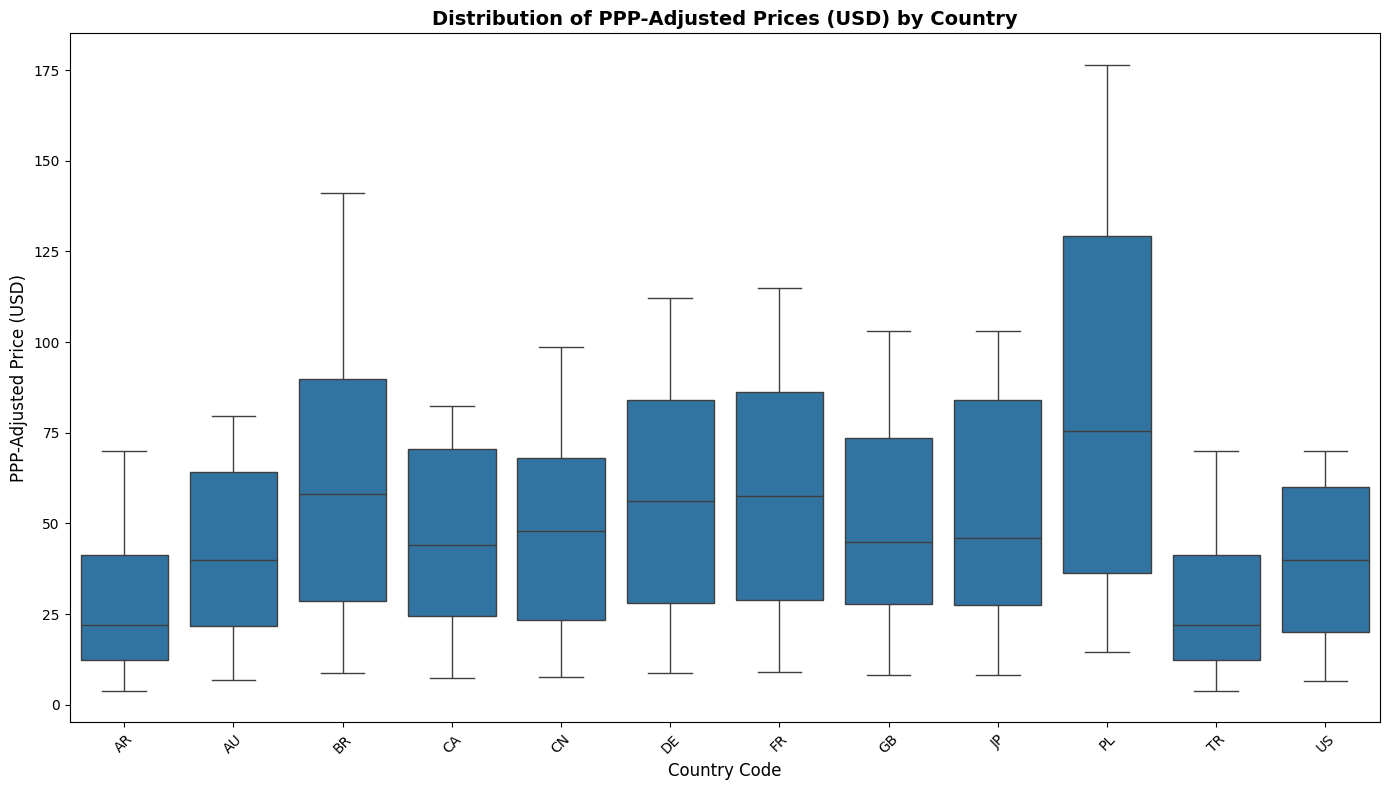

In [25]:
# Create output directory for plots if it doesn't exist
os.makedirs('plots', exist_ok=True)

# Plot 1: Distribution of PPP-Adjusted Prices by Country
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_final_merged, x='country', y='price_usd_ppp', order=sorted(df_final_merged['country'].unique()))
plt.title('Distribution of PPP-Adjusted Prices (USD) by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('PPP-Adjusted Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


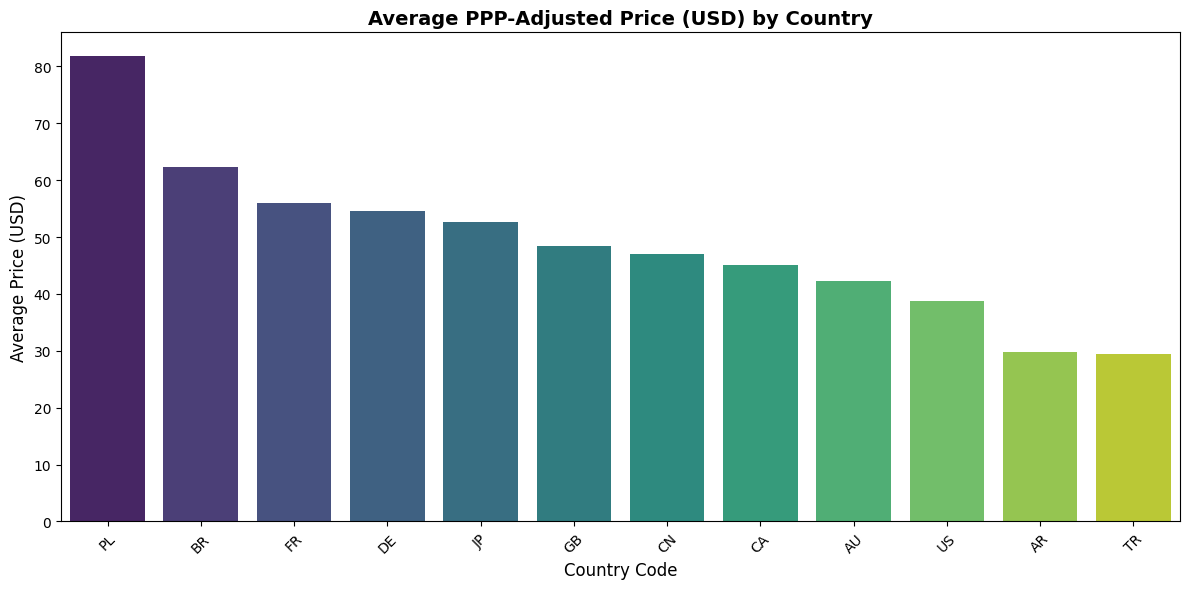

In [26]:
# Plot 2: Average PPP-Adjusted Price by Country
plt.figure(figsize=(12, 6))
avg_prices = df_final_merged.groupby('country')['price_usd_ppp'].mean().sort_values(ascending=False)
sns.barplot(x=avg_prices.index, y=avg_prices.values, palette='viridis')
plt.title('Average PPP-Adjusted Price (USD) by Country', fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Average Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

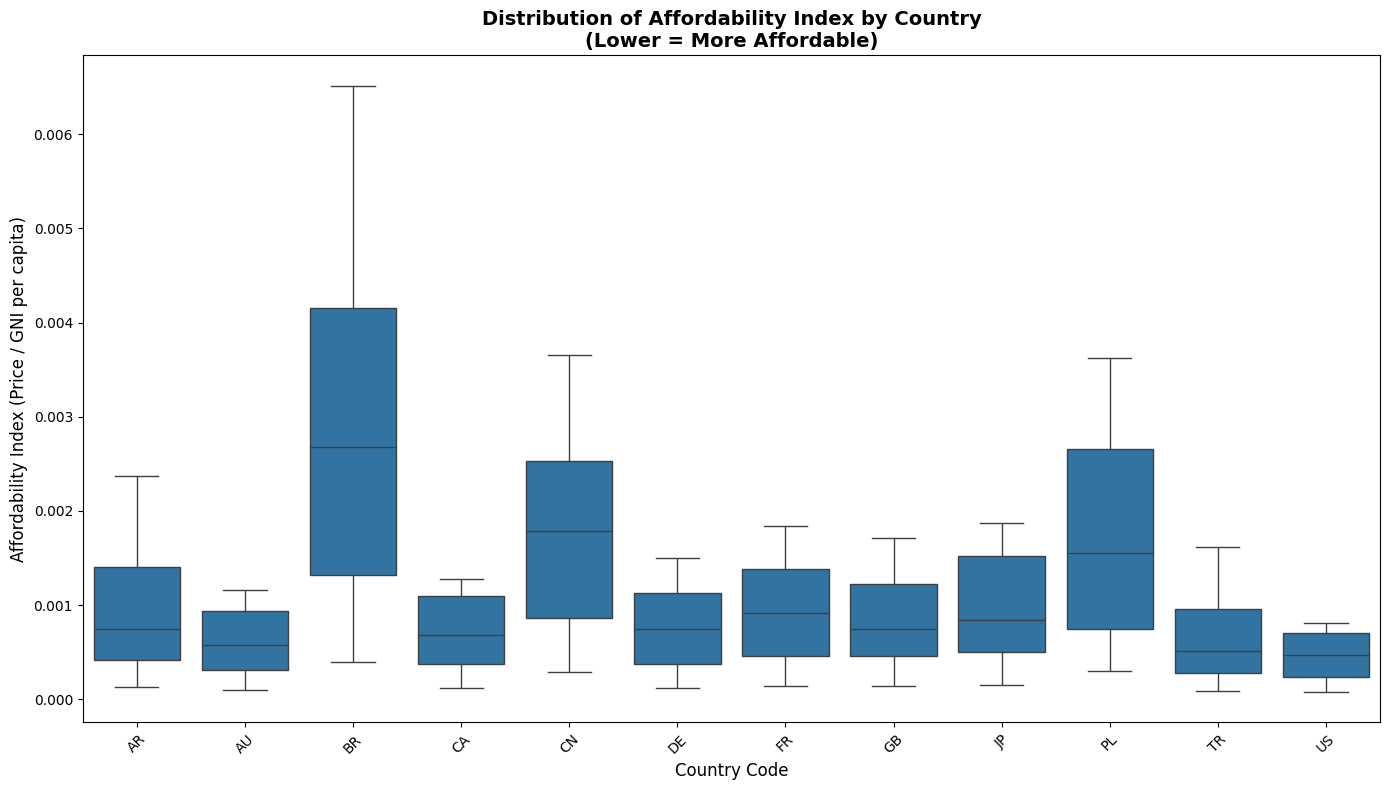

In [27]:
# Plot 3: Affordability Index by Country
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_final_merged, x='country', y='affordability_index', order=sorted(df_final_merged['country'].unique()))
plt.title('Distribution of Affordability Index by Country\n(Lower = More Affordable)', fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Affordability Index (Price / GNI per capita)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

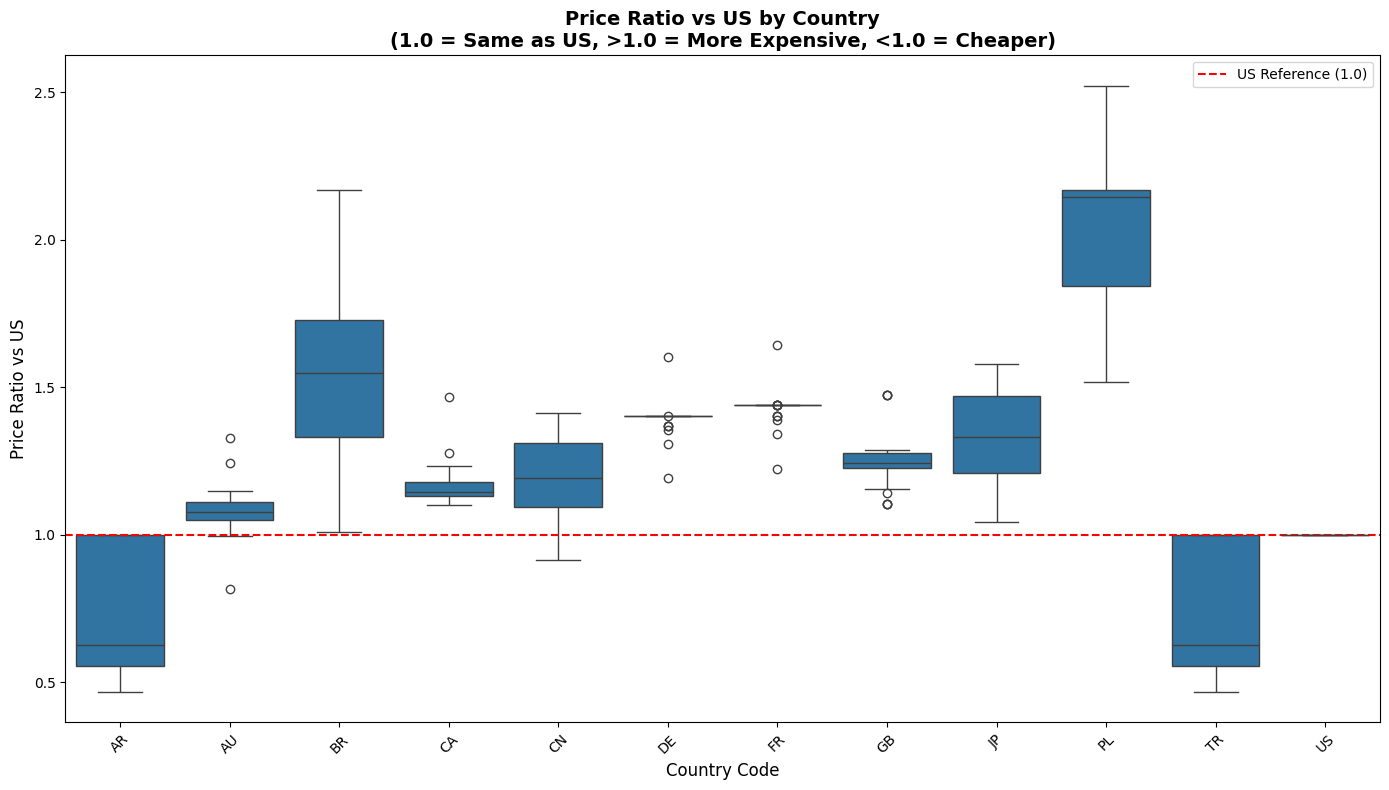

In [28]:
# Plot 4: Price Ratio vs US by Country
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_final_merged, x='country', y='price_ratio_vs_us', order=sorted(df_final_merged['country'].unique()))
plt.axhline(y=1.0, color='r', linestyle='--', label='US Reference (1.0)')
plt.title('Price Ratio vs US by Country\n(1.0 = Same as US, >1.0 = More Expensive, <1.0 = Cheaper)',
          fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Price Ratio vs US', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

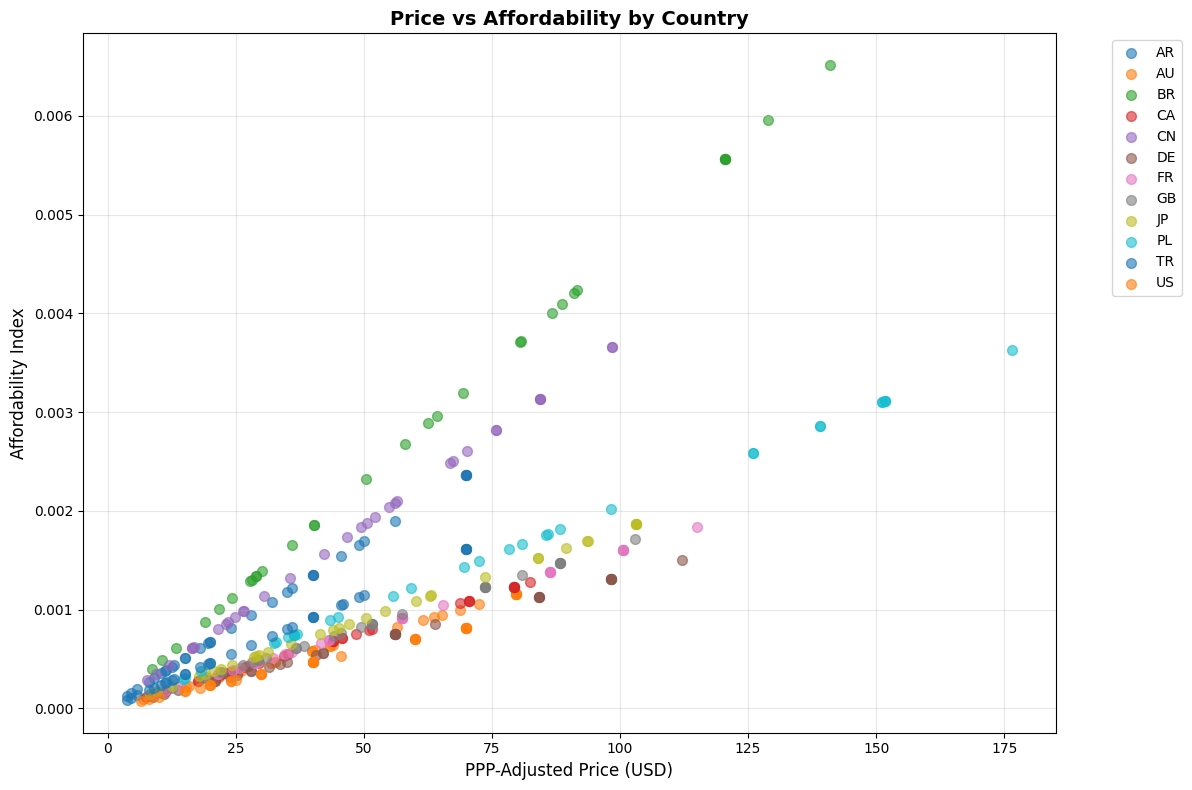

In [29]:
# Plot 5: Price vs Affordability Scatter
plt.figure(figsize=(12, 8))
for country in sorted(df_final_merged['country'].unique()):
    country_data = df_final_merged[df_final_merged['country'] == country]
    plt.scatter(country_data['price_usd_ppp'], country_data['affordability_index'],
               label=country, alpha=0.6, s=50)
plt.xlabel('PPP-Adjusted Price (USD)', fontsize=12)
plt.ylabel('Affordability Index', fontsize=12)
plt.title('Price vs Affordability by Country', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

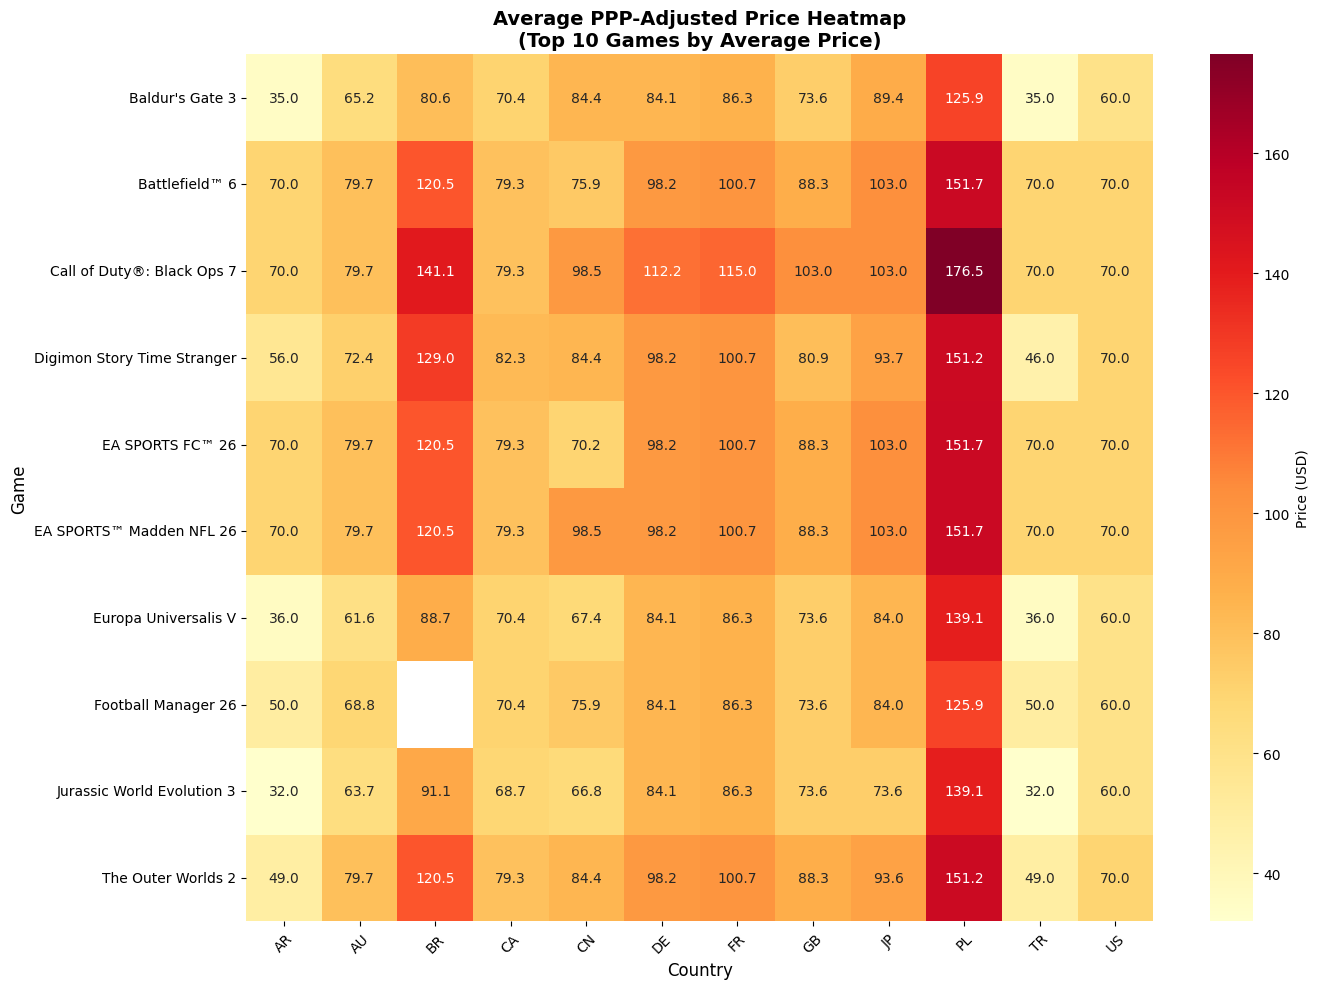

In [30]:
# Plot 6: Heatmap of Average Prices by Game and Country (sample of top games)
top_games = df_final_merged.groupby('name')['price_usd_ppp'].mean().nlargest(10).index
df_top_games = df_final_merged[df_final_merged['name'].isin(top_games)]
pivot_table = df_top_games.pivot_table(
    values='price_usd_ppp',
    index='name',
    columns='country',
    aggfunc='mean'
)
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Price (USD)'})
plt.title('Average PPP-Adjusted Price Heatmap\n(Top 10 Games by Average Price)', fontsize=14, fontweight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Game', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

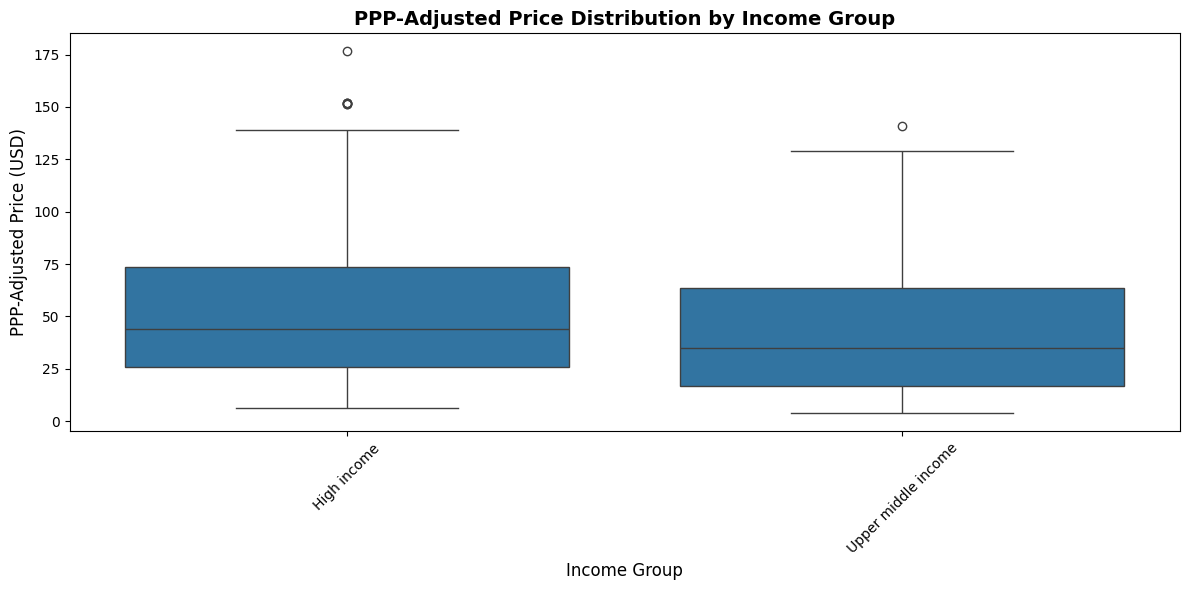

In [31]:
# Plot 7: Distribution by Income Group
if 'IncomeGroup' in df_final_merged.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_final_merged, x='IncomeGroup', y='price_usd_ppp', order=sorted(df_final_merged['IncomeGroup'].unique()))
    plt.title('PPP-Adjusted Price Distribution by Income Group', fontsize=14, fontweight='bold')
    plt.xlabel('Income Group', fontsize=12)
    plt.ylabel('PPP-Adjusted Price (USD)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

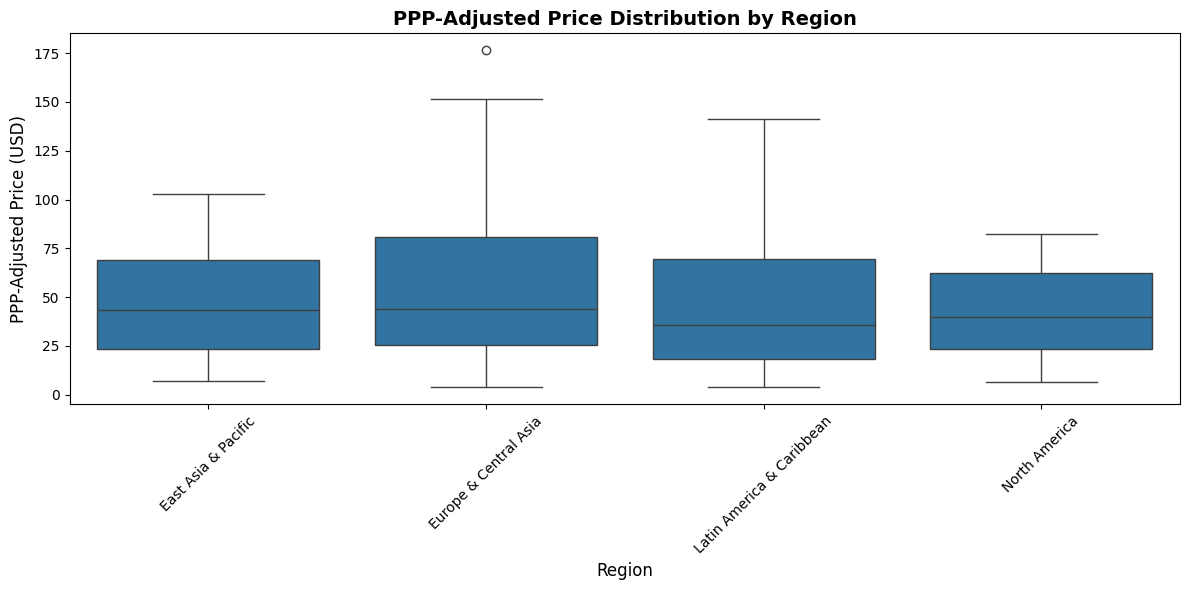

In [32]:
# Plot 8: Distribution by Region
if 'Region' in df_final_merged.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_final_merged, x='Region', y='price_usd_ppp', order=sorted(df_final_merged['Region'].unique()))
    plt.title('PPP-Adjusted Price Distribution by Region', fontsize=14, fontweight='bold')
    plt.xlabel('Region', fontsize=12)
    plt.ylabel('PPP-Adjusted Price (USD)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [35]:
# 4.5 Outlier Detection
# Identify games with extreme price differences across countries
price_stats = df_final_merged.groupby('appid')['price_usd_ppp'].agg(['min', 'max', 'mean', 'std'])
price_stats['price_range'] = price_stats['max'] - price_stats['min']
price_stats['price_cv'] = price_stats['std'] / price_stats['mean']  # Coefficient of variation
price_stats = price_stats.sort_values('price_cv', ascending=False)

display(price_stats.head(10))

,min,max,mean,std,price_range,price_cv
appid,,,,,,
2958130,31.99,139.077282,72.581028,28.072329,107.087282,0.386772
1466860,19.99,80.915577,44.275972,16.649980,60.925577,0.376050
1158310,8.99,35.195418,18.566918,6.909869,26.205418,0.372160
3241660,3.76,15.116986,7.838747,2.904627,11.356986,0.370547
3450310,35.99,139.077282,73.926005,27.138427,103.087282,0.367103
1627720,17.99,69.536112,38.482248,13.960688,51.546112,0.362783
2062430,7.99,32.363196,17.650923,6.361661,24.373196,0.360415
2592160,14.99,59.173214,33.888303,11.703473,44.183214,0.345354
1151340,23.99,85.927598,48.909069,16.783361,61.937598,0.343154


In [36]:
# 4.6 Summary Statistics
print("\n4.6 Final Summary")
print("-" * 80)
print("\nOverall Statistics:")
print(f"  - Mean PPP-adjusted price: ${df_final_merged['price_usd_ppp'].mean():.2f}")
print(f"  - Median PPP-adjusted price: ${df_final_merged['price_usd_ppp'].median():.2f}")
print(f"  - Price range: ${df_final_merged['price_usd_ppp'].min():.2f} - ${df_final_merged['price_usd_ppp'].max():.2f}")
print(f"  - Mean affordability index: {df_final_merged['affordability_index'].mean():.6f}")
print(f"  - Countries with highest avg price: {avg_prices.nlargest(3).index.tolist()}")
print(f"  - Countries with lowest avg price: {avg_prices.nsmallest(3).index.tolist()}")


4.6 Final Summary
--------------------------------------------------------------------------------

Overall Statistics:
  - Mean PPP-adjusted price: $48.99
  - Median PPP-adjusted price: $40.66
  - Price range: $3.76 - $176.51
  - Mean affordability index: 0.001091
  - Countries with highest avg price: ['PL', 'BR', 'FR']
  - Countries with lowest avg price: ['TR', 'AR', 'US']


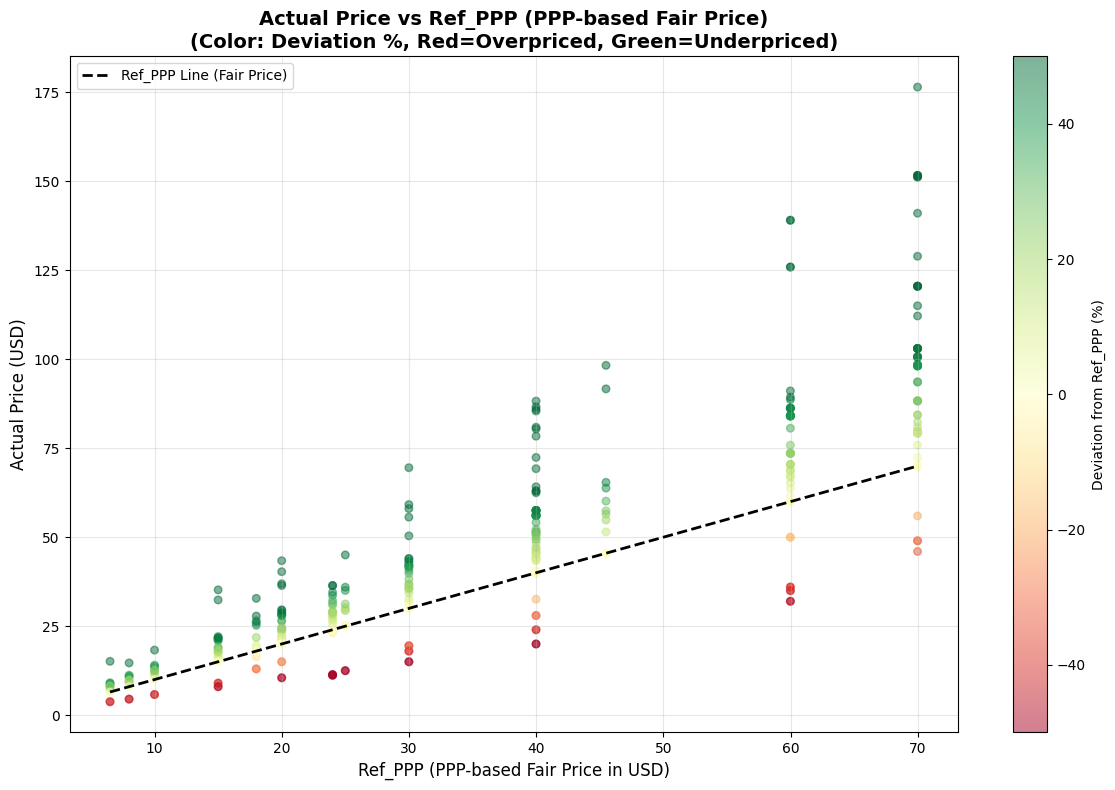

In [37]:
 # Plot 9: Actual Price vs Ref_PPP (PPP-based Fair Price)
plt.figure(figsize=(12, 8))
plt.scatter(df_final_merged['Ref_PPP_USD'], df_final_merged['price_usd_ppp'],
           alpha=0.5, s=30, c=df_final_merged['deviation_from_Ref_PPP_pct'],
           cmap='RdYlGn', vmin=-50, vmax=50)
plt.plot([df_final_merged['Ref_PPP_USD'].min(), df_final_merged['Ref_PPP_USD'].max()],
         [df_final_merged['Ref_PPP_USD'].min(), df_final_merged['Ref_PPP_USD'].max()],
         'k--', linewidth=2, label='Ref_PPP Line (Fair Price)')
plt.xlabel('Ref_PPP (PPP-based Fair Price in USD)', fontsize=12)
plt.ylabel('Actual Price (USD)', fontsize=12)
plt.title('Actual Price vs Ref_PPP (PPP-based Fair Price)\n(Color: Deviation %, Red=Overpriced, Green=Underpriced)',
          fontsize=14, fontweight='bold')
plt.colorbar(label='Deviation from Ref_PPP (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


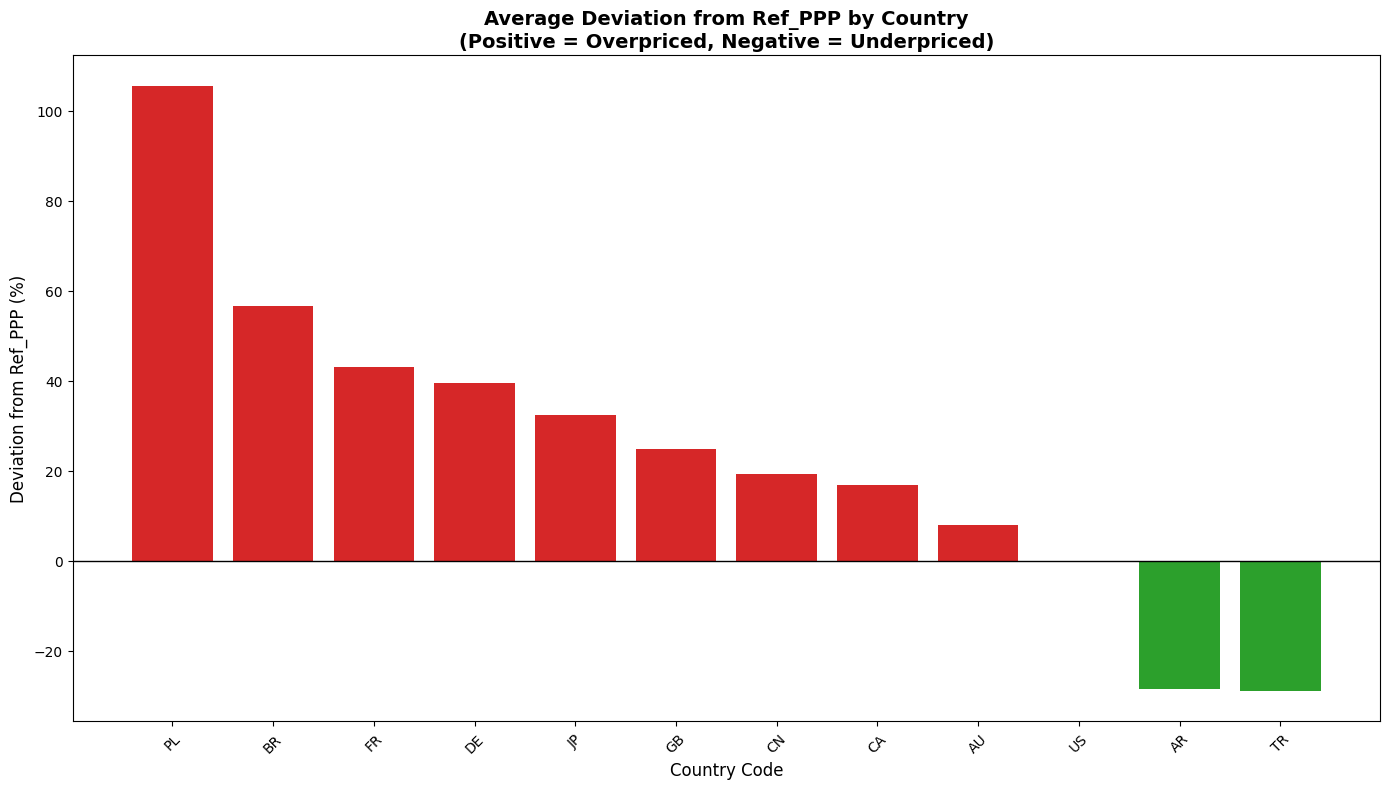

In [38]:
# Plot 10: Deviation from Ref_PPP by Country
plt.figure(figsize=(14, 8))
deviation_avg = df_final_merged.groupby('country')['deviation_from_Ref_PPP_pct'].mean().sort_values(ascending=False)
colors_bar = ['#d62728' if x > 0 else '#2ca02c' for x in deviation_avg.values]
bars = plt.bar(range(len(deviation_avg)), deviation_avg.values, color=colors_bar)
plt.xticks(range(len(deviation_avg)), deviation_avg.index, rotation=45)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.title('Average Deviation from Ref_PPP by Country\n(Positive = Overpriced, Negative = Underpriced)',
          fontsize=14, fontweight='bold')
plt.xlabel('Country Code', fontsize=12)
plt.ylabel('Deviation from Ref_PPP (%)', fontsize=12)
plt.tight_layout()
plt.show()